In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mat
import pickle
import sklearn as sk


%matplotlib inline
os.chdir('/Users/Eric/FamaFrench_IndustryFactorExposure')

In [2]:
df_dic= pickle.load( open( 'df_dic.p', 'rb'))
df_dic.keys()

dict_keys(['industry_avgBM', 'industry_BM', 'industry_compCount', 'factor_ret4', 'factor_ret', 'industry_avgMktCap', 'industry_ret', 'industry_ret_ew'])

In [3]:
factor_ret6= df_dic['factor_ret'][ ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']]
factor_ret6.corr()

,Mkt-RF,SMB,HML,RMW,CMA,MOM
Mkt-RF,1.000000,0.212153,-0.205727,-0.377459,-0.378396,-0.196804
SMB,0.212153,1.000000,-0.128341,-0.460804,-0.049179,0.021427
HML,-0.205727,-0.128341,1.000000,0.352587,0.656231,-0.200142
RMW,-0.377459,-0.460804,0.352587,1.000000,0.207063,0.081426
CMA,-0.378396,-0.049179,0.656231,0.207063,1.000000,0.048436
MOM,-0.196804,0.021427,-0.200142,0.081426,0.048436,1.000000


Note: CMA and HML shows corr of 0.65 and RMW and SMB shows corr of -0.46

In [4]:
factor_ret4= df_dic['factor_ret4'][[ 'Mkt-RF', 'SMB', 'HML', 'MOM']]
factor_ret4.corr()

,Mkt-RF,SMB,HML,MOM
Mkt-RF,1.000000,0.227021,-0.205727,-0.196804
SMB,0.227021,1.000000,-0.277006,0.060844
HML,-0.205727,-0.277006,1.000000,-0.200142
MOM,-0.196804,0.060844,-0.200142,1.000000


No significant correlation
 

The problem is variable selection: 

Shall we use the 6 factor model(full model ) or a simpler reduced model, eg the 4 factor model? 

The variable selection is industry dependent 

First check the properties of industry/factor ret series. 

//anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


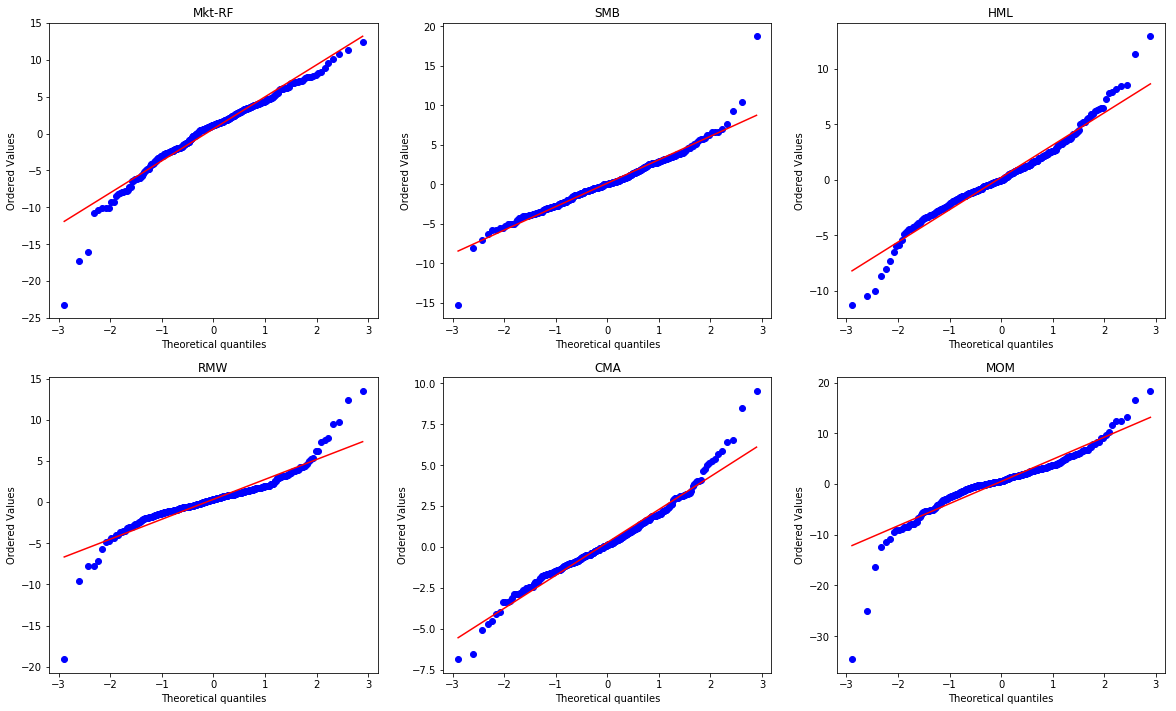

In [5]:
plt.figure(figsize= (20,25 ))
plt.subplot(2,3,1)
i= 1
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
for col in factor_ret6.columns:
    u= probplot( factor_ret6[col], plot= plt.subplot(4,3,i))
    i=i+1
    plt.title( col)

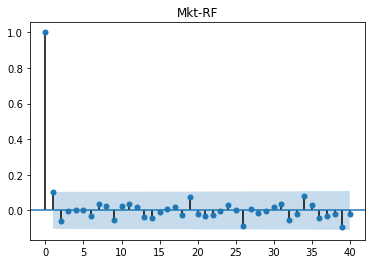

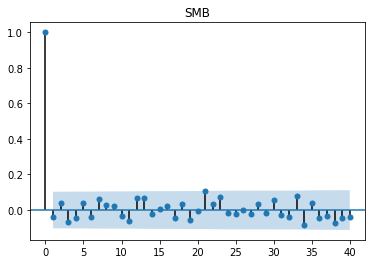

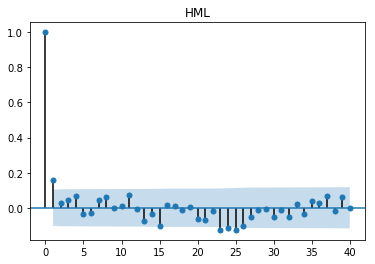

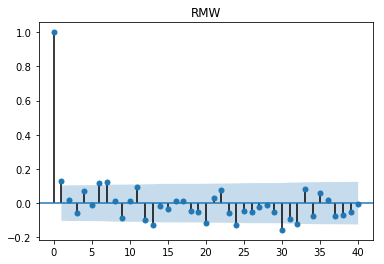

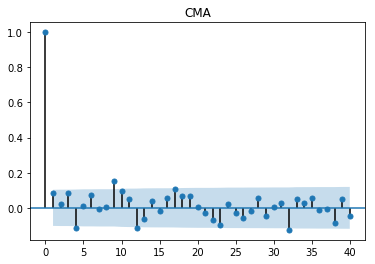

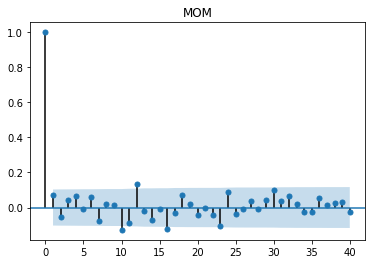

In [6]:

# f, ax= plt.subplots(2,3)
for col in factor_ret6.columns:
    g= plot_acf( factor_ret6[col], lags= 40) 
    plt.title( col)

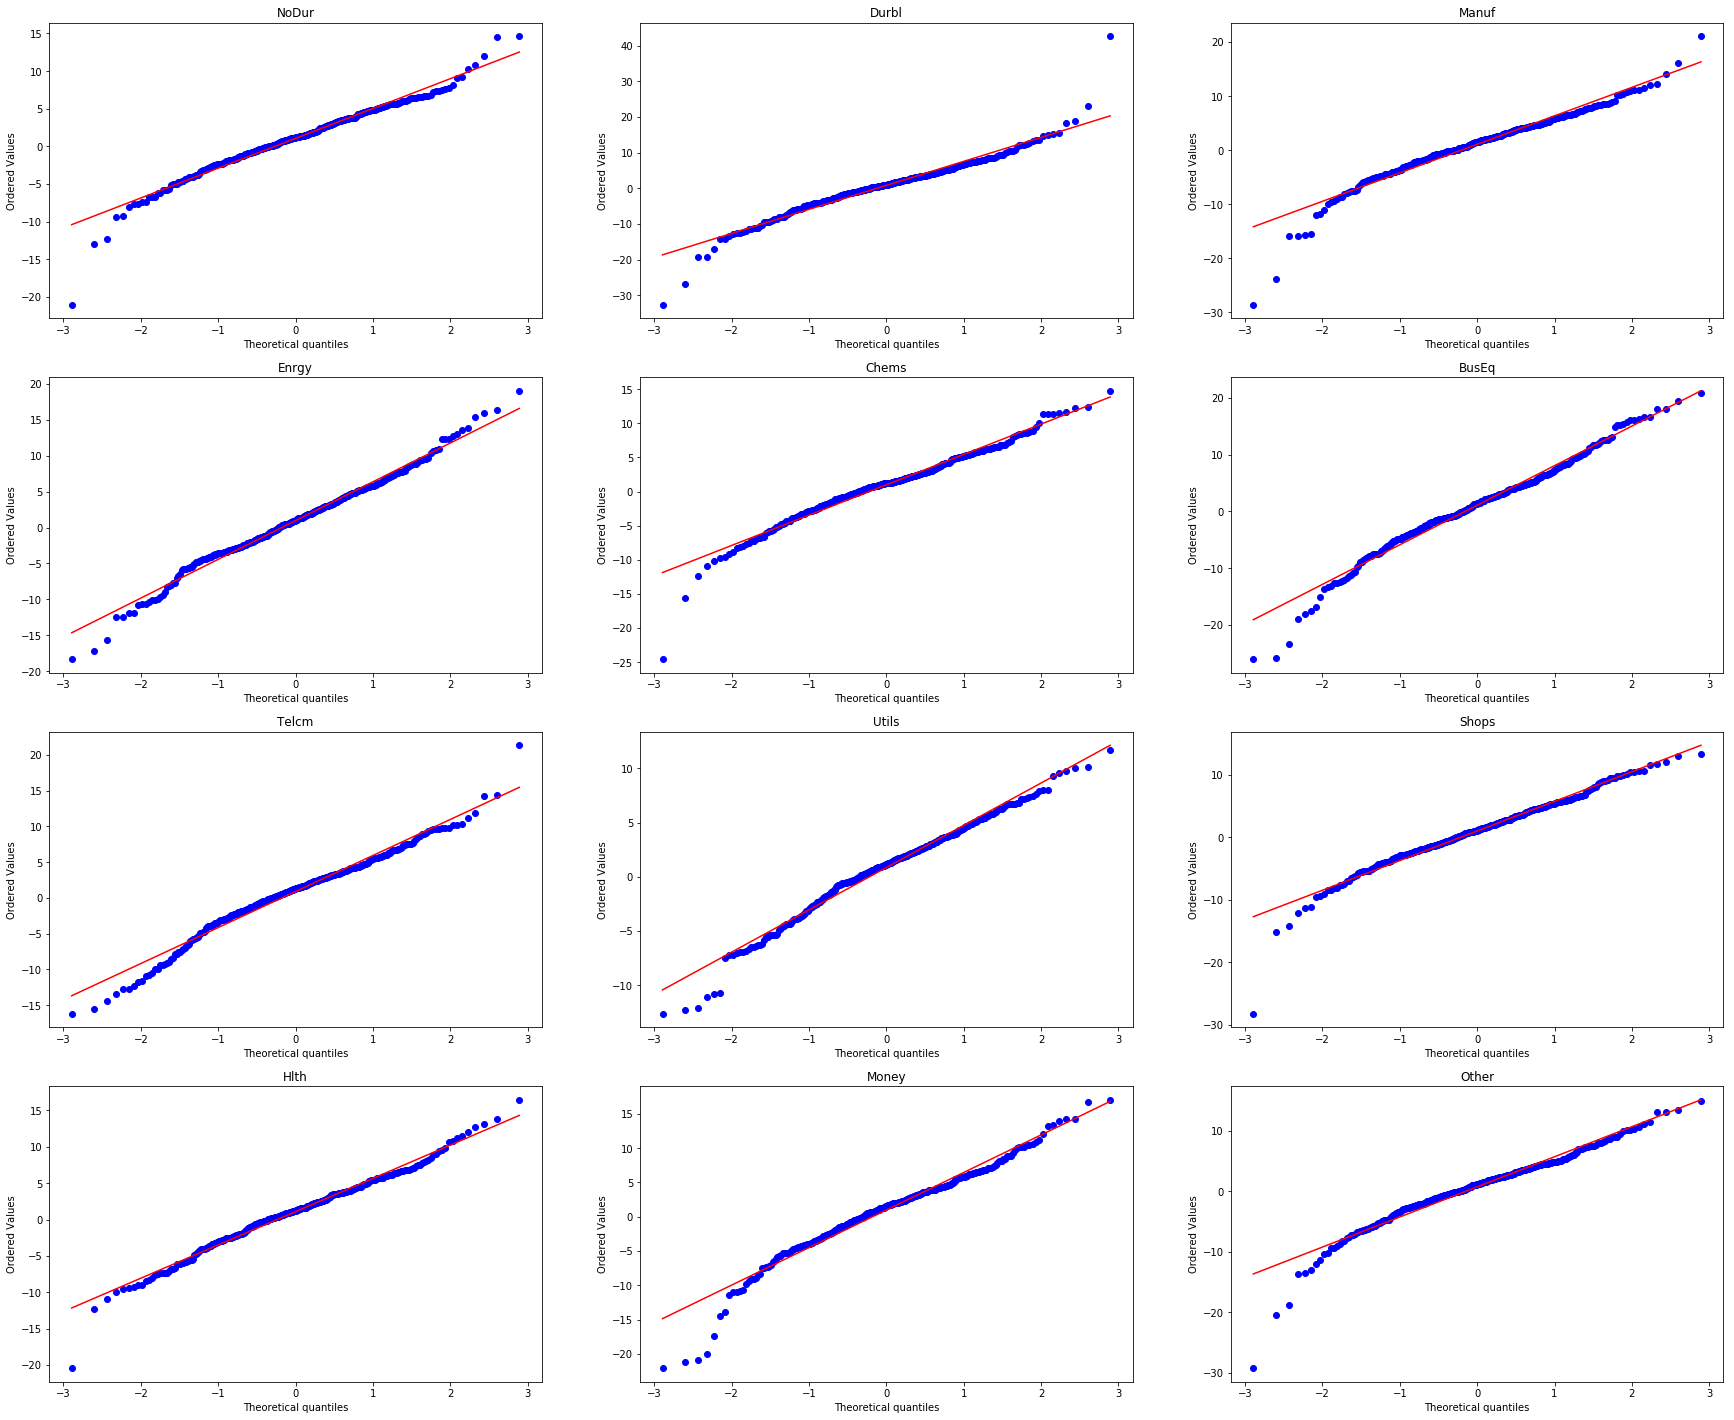

In [7]:
industry_ret= df_dic[ 'industry_ret']
plt.figure( figsize= (30, 25))
i=1
plt.subplot( 4,3,i)
for col in industry_ret.columns:
    u= probplot( industry_ret[col], plot= plt.subplot(4,3,i))
    plt.title( col)
    i+=1

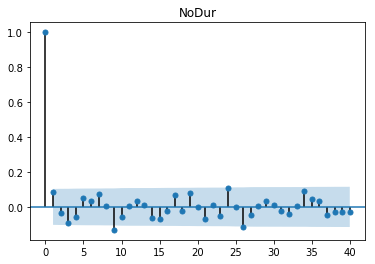

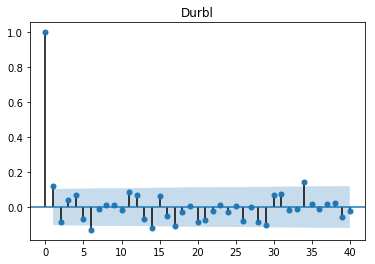

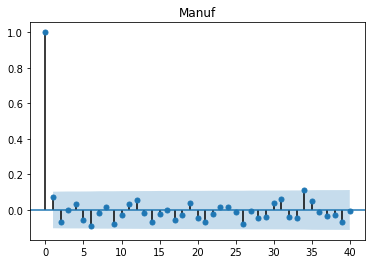

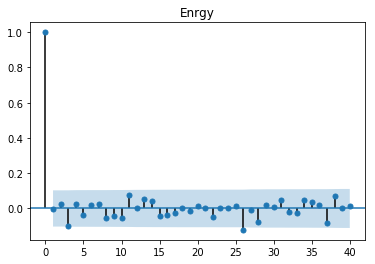

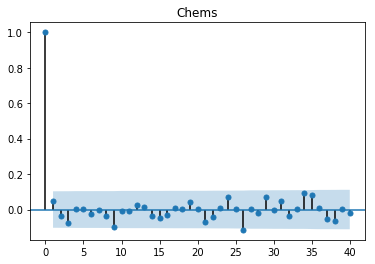

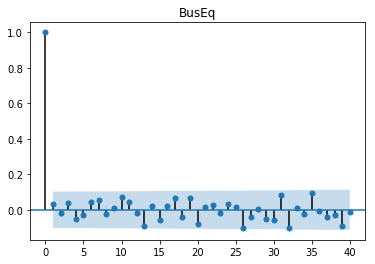

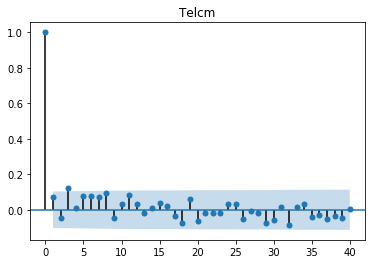

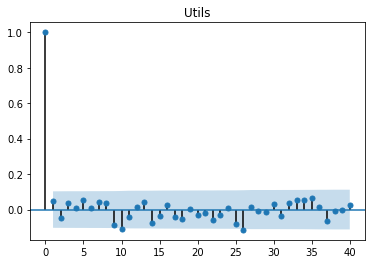

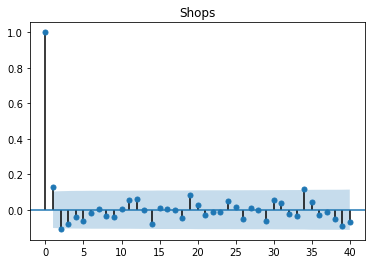

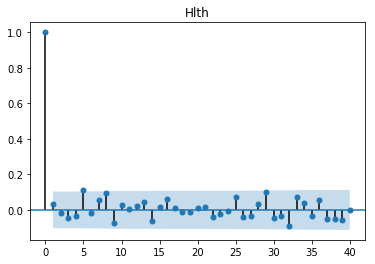

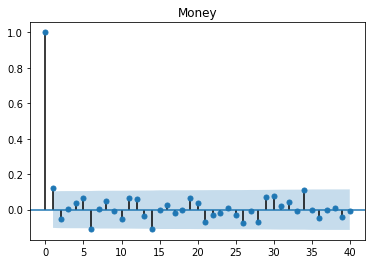

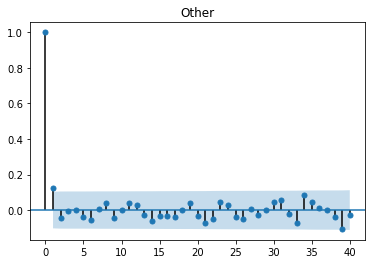

In [8]:
for col in industry_ret.columns:
    g= plot_acf( industry_ret[col], lags= 40 )
    plt.title( col)

Note: 

The qq plot and emprical ACF plot shows that: 

1. Both industry and factor portfolios returns have no significant auto correlation. Permutation of the return data are allowed. 

2. Both industry and factor portfolios returns show roughly symmetric return distribution. The distribution tail is fat, especially for left tail, which is a common issue for financial market return data. 



### Estimate Industry Factor Loading 


##### 6 Factors VS 4 Factors 

Classical FF factor model originates as a 4 factor model, then develop to 6 factors. The two new comers are CMA and RMW. The correlation matrix above highlights the correlated pair CMA&HML and RMW&SMB. To maintain a simple and low-variance model, variable selection is attractive. 

I use lasso to select the most significant factor for each industry then estimate loadings over the selected factors. 

In [9]:
# industry_ret
# factor_ret6
# factor_ret4
RF= df_dic[ 'factor_ret']['RF']

In [10]:
factor_ret4

,Mkt-RF,SMB,HML,MOM
1987-01-01,12.47,-1.80,-3.17,2.09
1987-02-01,4.39,3.49,-5.98,-2.17
1987-03-01,1.64,0.37,1.64,1.59
1987-04-01,-2.11,-1.70,-0.32,0.25
1987-05-01,0.11,-0.52,0.12,-0.69
1987-06-01,3.94,-2.19,1.06,-0.20
1987-07-01,3.85,-0.63,0.71,2.67
1987-08-01,3.52,-0.75,-0.93,-0.87
1987-09-01,-2.59,0.53,0.28,0.71
1987-10-01,-23.24,-8.42,4.23,-7.86


In [11]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm


# industries= industry_ret.columns
# tmp_X= sm.add_constant( factor_ret6)
# ALPHA= np.exp( np.linspace(start= -15, stop= -1, num= 300))+ 1e-3
# industry_cv= {}
# K =10 
# i=0 
# for ind in industries:
#     y= industry_ret[ind]- RF
#     cv_scores= {} # cv scores array
#     cv_res= [] # alpha, score mean, score std
#     cv_params= [] # alpha, estimated betas 
    
    
#     for alpha in ALPHA: 
#         lasso_model= Lasso( alpha= alpha)
#         scores= cross_val_score( lasso_model, X= tmp_X, y = y , cv=K, scoring= 'neg_mean_absolute_error' )
#         cv_scores[ alpha]= scores
#         cv_res.append( [ alpha, np.mean(scores), np.std(scores)])
#         lasso_model.fit( X=tmp_X, y=y)
#         cv_params.append( [alpha]+ lasso_model.coef_.tolist( ))
    
#     cv_res= pd.DataFrame(cv_res)
#     cv_res.columns= ['alpha', 'negMAE_mean', 'negMAE_std']
#     cv_res.set_index( keys= 'alpha', inplace= True)
#     cv_params= pd.DataFrame( cv_params)
#     cv_params.columns=  ['alpha', 'intercept', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
#     cv_params.set_index( keys= 'alpha', inplace= True)
    
#     industry_cv[ind]= (cv_scores, cv_res, cv_params)
    
# pickle.dump( industry_cv, open( 'industry_cv.p', 'wb'))


In [12]:
industry_cv = pickle.load( open( 'industry_cv.p', 'rb'))
industry_cv.keys()

dict_keys(['Durbl', 'BusEq', 'Chems', 'Utils', 'Hlth', 'Manuf', 'Telcm', 'NoDur', 'Money', 'Shops', 'Enrgy', 'Other'])

//anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


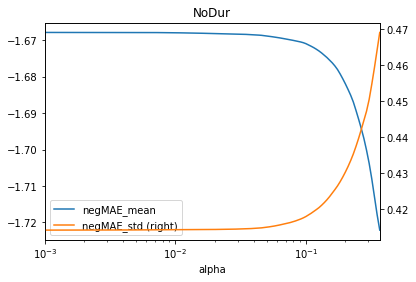

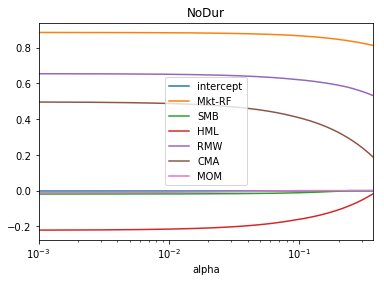

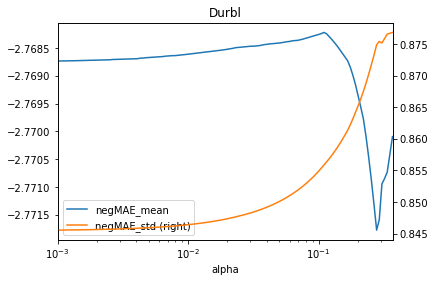

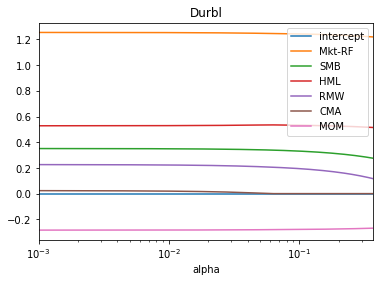

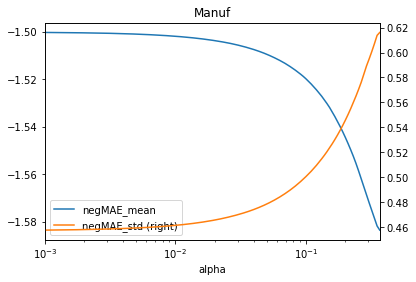

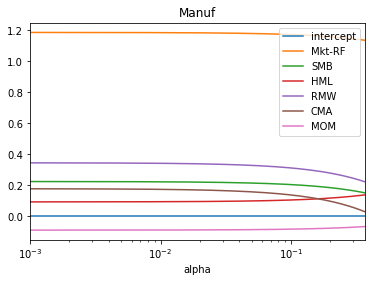

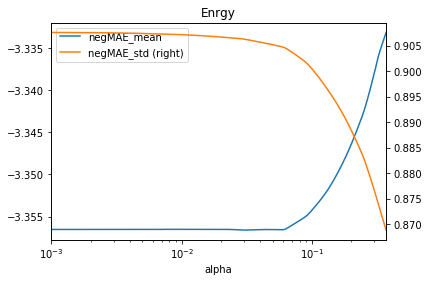

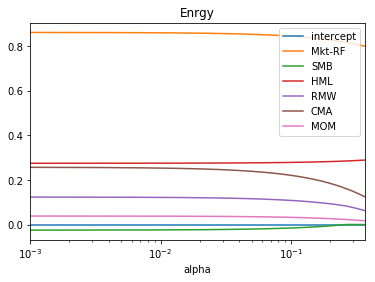

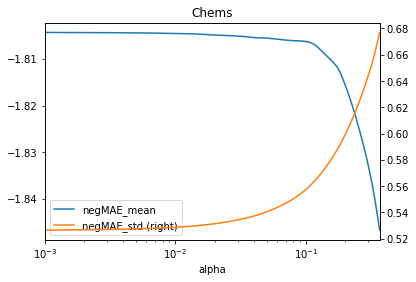

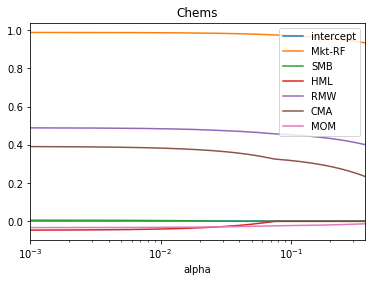

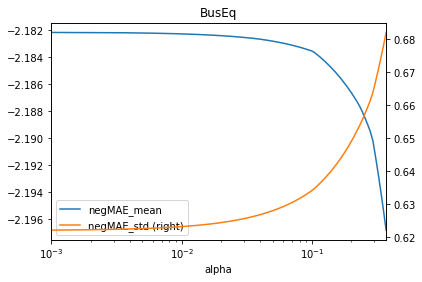

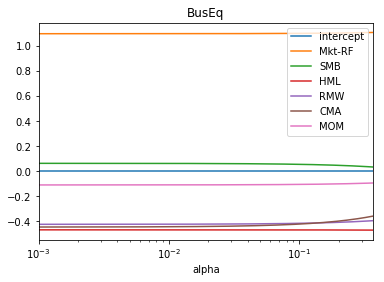

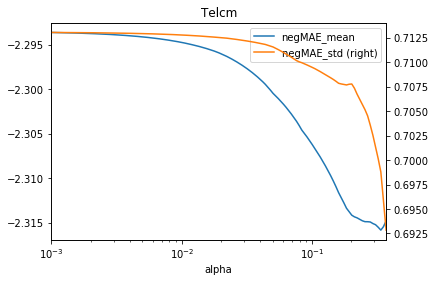

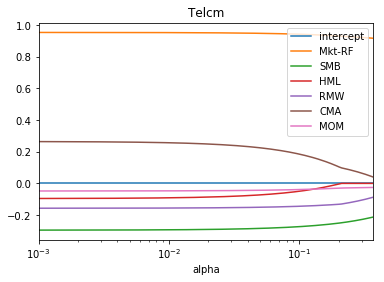

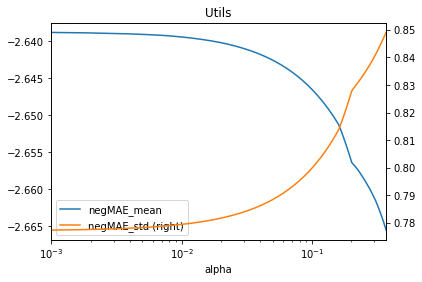

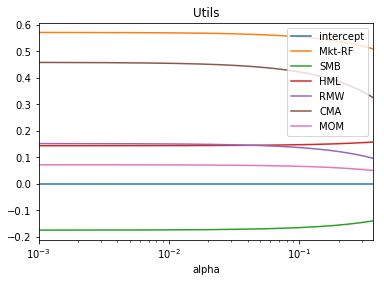

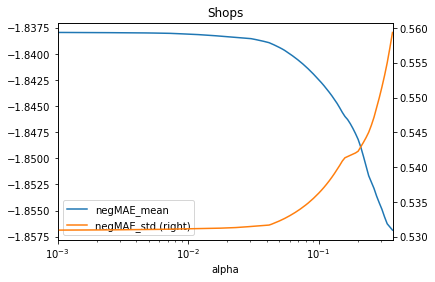

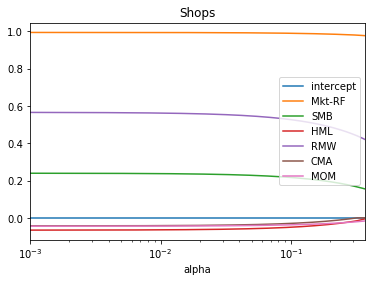

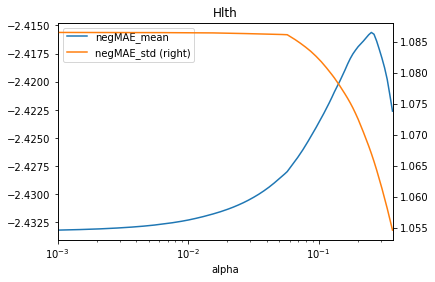

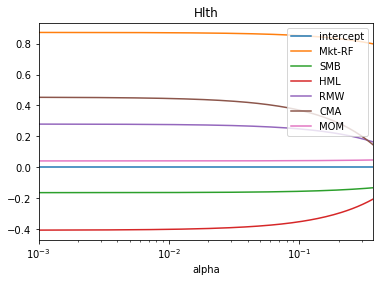

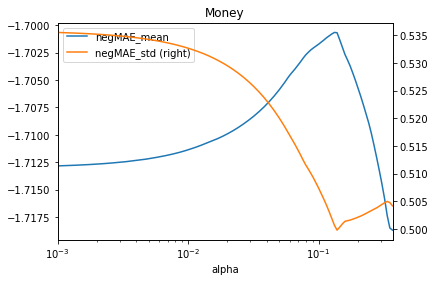

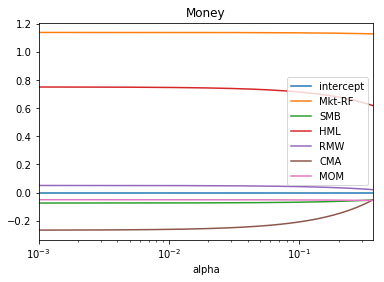

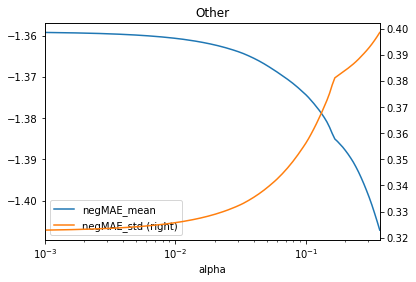

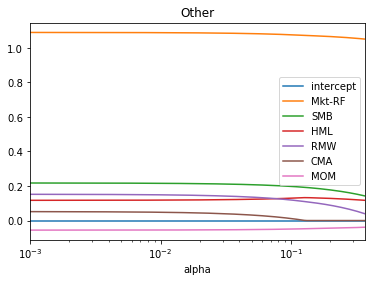

In [13]:
ind= 'Utils'

for ind in industry_ret.columns: 
    industry_cv[ind][1] .plot(secondary_y = ['negMAE_std'],  logx= True)
    plt.title( ind)
    industry_cv[ind][2].plot(logx=True)
    plt.title( ind)


In [14]:
industry_factor= {}
industry_factor['Telcm']= ['Mkt-RF', 'SMB']
industry_factor['BusEq']= ['Mkt-RF', 'HML', 'MOM', 'CMA', 'RMW', 'SMB']
industry_factor['NoDur']= ['Mkt-RF', 'RMW', 'CMA', 'HML']
industry_factor['Shops']= ['Mkt-RF', 'RMW', 'SMB', 'HML', 'MOM']
industry_factor['Durbl']= ['Mkt-RF', 'HML', 'SMB', 'RMW', 'MOM']
industry_factor['Hlth']=  ['Mkt-RF', 'MOM', 'SMB', 'HML']
industry_factor['Utils']= ['Mkt-RF', 'HML', 'RMW', 'MOM', 'SMB']
industry_factor['Chems']=['Mkt-RF', 'RMW', 'CMA']
industry_factor['Money']= factor_ret6.columns
industry_factor['Manuf']= ['Mkt-RF', 'MOM', 'HML', 'SMB', 'RMW']
industry_factor['Enrgy']=['Mkt-RF', 'HML']
industry_factor['Other']= ['Mkt-RF', 'HML', 'SMB', 'MOM']

pickle.dump( industry_factor, open( 'industry_factor.p', 'wb') )

In [15]:
industry_longtermModel= {}
for ind in industry_ret.columns:
    y= industry_ret[ind]-RF
    tmpX= factor_ret6[ industry_factor[ind]]
    lm= sm.OLS(exog= tmpX, endog= y)
    lm_res= lm.fit()
    industry_longtermModel[ind]= lm_res
    
pickle.dump( industry_longtermModel, open('industry_longtermModel.p', 'wb'))

In [16]:
# print(industry_longtermModel['NoDur'].summary())
industry_longtermBeta= pd.DataFrame()
industry_longtermBetaStd= pd.DataFrame()
for key, val in industry_longtermModel.items():
    beta= pd.DataFrame( val.params) 
    beta.columns= [key]
    industry_longtermBeta= pd.concat( [industry_longtermBeta, beta], axis=1, join= 'outer')
    betastd= pd.DataFrame( val.bse)
    betastd.columns= [key]
    industry_longtermBetaStd= pd.concat([industry_longtermBetaStd, betastd], axis=1, join= 'outer')

pickle.dump(industry_longtermBeta, open('industry_longtermBeta', 'wb'))
pickle.dump(industry_longtermBetaStd, open( 'industry_longtermBetaStd', 'wb'))

In [17]:
industry_longtermBeta

,Durbl,BusEq,Chems,Utils,Hlth,Manuf,Telcm,NoDur,Money,Shops,Enrgy,Other
CMA,NaN,-0.386500,0.334378,NaN,NaN,NaN,NaN,0.477713,-0.278814,NaN,NaN,NaN
HML,0.529336,-0.480025,NaN,0.361020,-0.119600,0.171132,NaN,-0.211013,0.752355,-0.088574,0.403826,0.165618
MOM,-0.293144,-0.097763,NaN,0.102822,0.094712,-0.082888,NaN,NaN,-0.053120,-0.050241,NaN,-0.052798
Mkt-RF,1.233520,1.129099,0.979997,0.520666,0.801332,1.160124,0.956367,0.881171,1.129934,0.995415,0.798757,1.053079
RMW,0.196681,-0.377106,0.458930,0.113512,NaN,0.320020,NaN,0.655864,0.041256,0.563473,NaN,NaN
SMB,0.341331,0.076576,NaN,-0.162858,-0.229492,0.224016,-0.231990,NaN,-0.077155,0.236105,NaN,0.169514


In [18]:
industry_longtermBetaStd

,Durbl,BusEq,Chems,Utils,Hlth,Manuf,Telcm,NoDur,Money,Shops,Enrgy,Other
CMA,NaN,0.098835,0.063004,NaN,NaN,NaN,NaN,0.074120,0.077827,NaN,NaN,NaN
HML,0.069174,0.070946,NaN,0.064685,0.056767,0.037209,NaN,0.051487,0.055866,0.043804,0.074735,0.032209
MOM,0.041334,0.032434,NaN,0.038652,0.035584,0.022234,NaN,NaN,0.025540,0.026175,NaN,0.020190
Mkt-RF,0.044977,0.036140,0.030239,0.042058,0.038225,0.024193,0.035603,0.027523,0.028458,0.028482,0.049533,0.021688
RMW,0.086817,0.067056,0.049174,0.081183,NaN,0.046699,NaN,0.046695,0.052802,0.054977,NaN,NaN
SMB,0.068361,0.052496,NaN,0.063924,0.054168,0.036771,0.052321,NaN,0.041338,0.043289,NaN,0.030734


In [19]:
industry_longtermBeta/ industry_longtermBetaStd

,Durbl,BusEq,Chems,Utils,Hlth,Manuf,Telcm,NoDur,Money,Shops,Enrgy,Other
CMA,NaN,-3.910566,5.307253,NaN,NaN,NaN,NaN,6.445109,-3.582503,NaN,NaN,NaN
HML,7.652190,-6.766056,NaN,5.581213,-2.106873,4.599256,NaN,-4.098364,13.467193,-2.022025,5.403451,5.141997
MOM,-7.091989,-3.014197,NaN,2.660220,2.661653,-3.728052,NaN,NaN,-2.079870,-1.919448,NaN,-2.615079
Mkt-RF,27.425269,31.242629,32.408141,12.379613,20.963828,47.952513,26.862175,32.016363,39.705544,34.949081,16.125920,48.555326
RMW,2.265453,-5.623779,9.332785,1.398229,NaN,6.852885,NaN,14.045796,0.781324,10.249285,NaN,NaN
SMB,4.993056,1.458706,NaN,-2.547664,-4.236688,6.092178,-4.433965,NaN,-1.866463,5.454094,NaN,5.515464


In [20]:
## Check the rolling regression

from  rolling import rolling_reg

ind= 'Durbl'
break_index= [str(x)+ '-03-01' for x in range( 1997, 2018,1)]
window_size=200

y= industry_ret[ind]-RF
X= factor_ret6[industry_factor[ind]]

rolling_model= rolling_reg( X= X, y =y ,window_size= window_size, rolling_index= break_index)

In [21]:

rolling_beta= pd.DataFrame()
for key, val in rolling_model.items():
    beta= pd.DataFrame( val.params)
    beta.columns= [key]
    rolling_beta= pd.concat( [rolling_beta, beta] , axis= 1 )
rolling_beta= rolling_beta.transpose()
rolling_beta.sort_index( inplace= True)

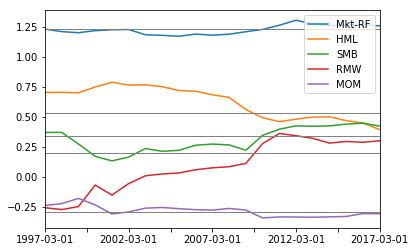

In [22]:
p= rolling_beta.plot()
M= industry_longtermModel[ind]
params= M.params
for f in params.index:
    plt.axhline( y= params[f], color= 'grey', linewidth= '1')

# rolling_model

# print( M.summary())

In [23]:
rolling_model['1999-03-01'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.752
Model:                            WLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     85.41
Date:                Sat, 08 Jul 2017   Prob (F-statistic):           6.51e-41
Time:                        18:57:11   Log-Likelihood:                -361.59
No. Observations:                 146   AIC:                             733.2
Df Residuals:                     141   BIC:                             748.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.1993      0.061     19.582      0.000       1.078       1.320
HML            0.6991      0.115      6.076      0.000       0.472       0.927
SMB            0.2727      0.101      2.689      0.008       0.072       0.473
RMW           -0.2480      0.181     -1.369      0.173      -0.606       0.110
MOM           -0.1800      0.087     -2.059      0.041      -0.353      -0.007
==============================================================================
Omnibus:                       17.091   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.733
Skew:                           0.638   Prob(JB):                     4.26e-06
Kurtosis:                       4.561   Cond. No.                         3.65
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
industry_longtermModel[ind].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     214.5
Date:                Sat, 08 Jul 2017   Prob (F-statistic):          2.42e-105
Time:                        18:57:11   Log-Likelihood:                -967.05
No. Observations:                 363   AIC:                             1944.
Df Residuals:                     358   BIC:                             1964.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt-RF         1.2335      0.045     27.425      0.000       1.145       1.322
HML            0.5293      0.069      7.652      0.000       0.393       0.665
SMB            0.3413      0.068      4.993      0.000       0.207       0.476
RMW            0.1967      0.087      2.265      0.024       0.026       0.367
MOM           -0.2931      0.041     -7.092      0.000      -0.374      -0.212
==============================================================================
Omnibus:                       14.018   Durbin-Watson:                   2.105
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               30.738
Skew:                           0.083   Prob(JB):                     2.11e-07
Kurtosis:                       4.416   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now we have 3 models:

1. 6 Factor Model ( Full Model) 
2. 4 Factor Model ( Simple Model) 
3. Industry Customized Model 

Which one is better? 

A competition of the 3 candidates: Rolling regression to revaluate the 3 models, compare the out of sample MAE. The one with smallest MAE will win. 


In [70]:
from rolling import rolling_reg

break_index= [str(x)+ '-03-01' for x in range( 1996, 2018,1)]
window_size= 150

X1= factor_ret6
X2= factor_ret6[['Mkt-RF', 'HML', 'SMB', 'MOM']]

M1_rollingModel= {}
M2_rollingModel= {}
M3_rollingModel= {} # key is industry, val is dict mapping break index to rolling model


for ind in industry_ret.columns:
    y= industry_ret[ ind]-RF
    M1_rollingModel[ind]= rolling_reg( X= X1, y=y, window_size= window_size, rolling_index= break_index)
    M2_rollingModel[ind]= rolling_reg( X= X2, y=y, window_size= window_size, rolling_index= break_index)
    X3= factor_ret6[ industry_factor[ ind]]
    M3_rollingModel[ind]= rolling_reg( X= X3, y=y, window_size= window_size, rolling_index= break_index)
    
pickle.dump( M1_rollingModel, open( 'M1_rollingModel.p', 'wb'))
pickle.dump( M2_rollingModel, open( 'M2_rollingModel.p', 'wb'))
pickle.dump( M3_rollingModel, open( 'M3_rollingModel.p', 'wb'))

In [71]:
from rolling import rolling_forecast
M1_rollingPred= {}
M2_rollingPred= {}
M3_rollingPred= {}
X1= factor_ret6
X2= factor_ret6[['Mkt-RF', 'HML', 'SMB', 'MOM']]

pred_OOS= {}
for ind in industry_ret.columns:
    pred_oos= {}
    y= industry_ret[ind]-RF
    
    ycap_M1= rolling_forecast( X= X1, rolling_model= M1_rollingModel[ind])
    ycap_M2= rolling_forecast( X= X2, rolling_model= M2_rollingModel[ind])
    X3= factor_ret6[industry_factor[ ind]]
    ycap_M3= rolling_forecast( X= X3, rolling_model= M3_rollingModel[ind])
    
    pred_oos['y']= y.loc[ ycap_M1.index].tolist()
    pred_oos['ycap_M1']= ycap_M1.tolist()
    pred_oos['ycap_M2']= ycap_M2.tolist()
    pred_oos['ycap_M3']= ycap_M3.tolist()
    
    pred_oos= pd.DataFrame( pred_oos, index= ycap_M1.index)
    pred_OOS[ind]= pred_oos
    
    

In [72]:


ModelMAE_OOS= {}
for ind, val in pred_OOS.items():
    ModelMAE_OOS[ind]= [ metrics.mean_absolute_error( y_true= val['y'], y_pred= val['ycap_M1']),
                       metrics.mean_absolute_error( y_true= val['y'], y_pred= val['ycap_M2']),
                       metrics.mean_absolute_error( y_true= val['y'], y_pred= val['ycap_M3'])]
    
ModelMAE_OOS= pd.DataFrame( ModelMAE_OOS, index= ['M1', 'M2', 'M3'])

In [73]:
ModelMAE_OOS

,BusEq,Chems,Durbl,Enrgy,Hlth,Manuf,Money,NoDur,Other,Shops,Telcm,Utils
M1,2.179141,1.924149,2.883029,3.781003,2.529682,1.602913,1.727501,1.730261,1.388204,1.878738,2.556559,2.913622
M2,2.250149,2.028248,2.883457,3.624682,2.477080,1.734466,1.742564,2.095873,1.364936,2.085162,2.450636,2.915570
M3,2.179141,1.840403,2.874452,3.534295,2.477080,1.592012,1.727501,1.706915,1.364936,1.856558,2.335407,2.892400


In [29]:
industry_factor['Hlth']

['Mkt-RF', 'MOM', 'SMB', 'HML']

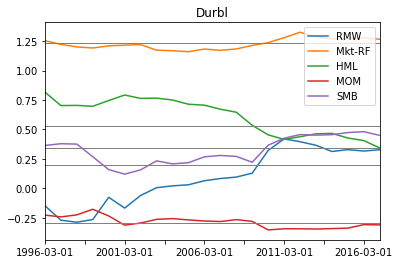

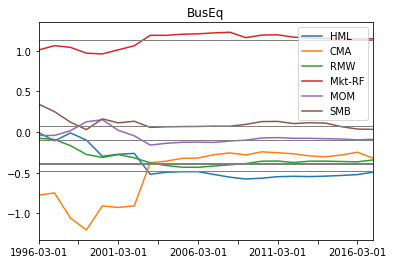

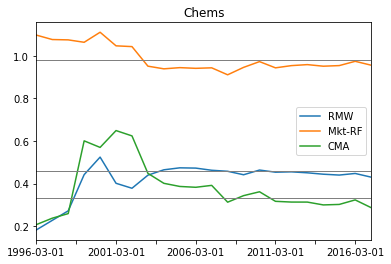

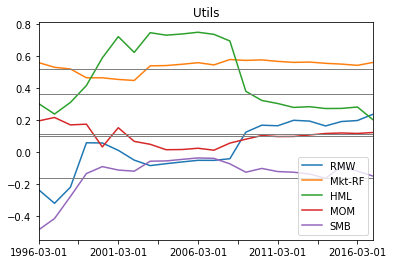

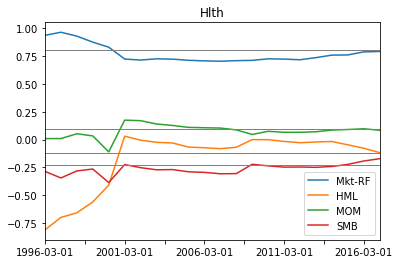

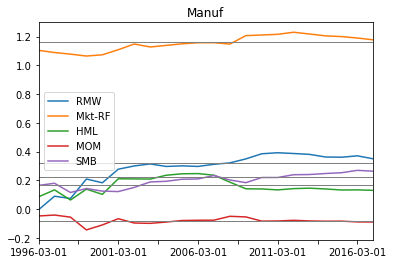

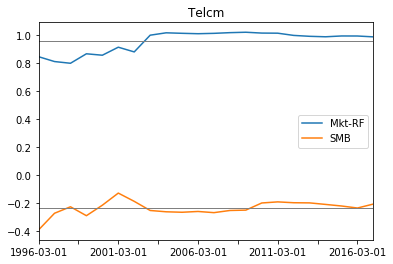

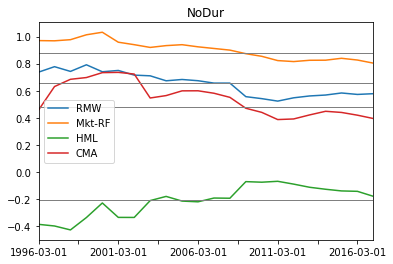

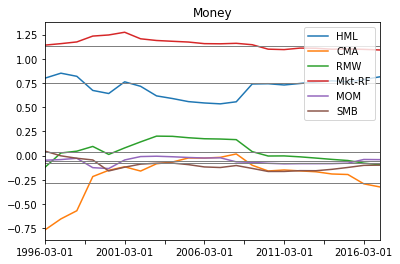

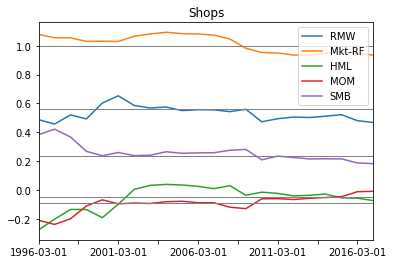

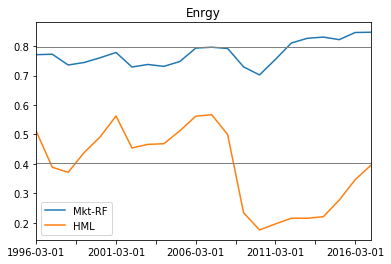

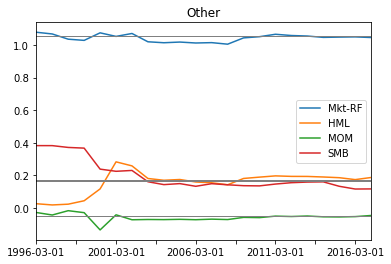

In [30]:
industry_rollingBeta= {}

for key, val in M3_rollingModel.items( ):
    
    tmp = pd.concat( [pd.DataFrame(x.params.tolist() + [x.rsquared ,np.mean(np.abs(x.resid))], 
                                   columns=[k],
                                  index= x.params.index.tolist()+ ['R_SQ','MAE']) for k ,x in val.items()], axis= 1 )
    tmp= tmp.T
    tmp.sort_index(inplace=True ) 
    tmp[list(set(tmp.columns )- set( ('MAE', 'R_SQ')))].plot()
    M= industry_longtermModel[key]
    for f in M.params.index:
        plt.axhline( y= M.params[f], lw= 1, color= 'grey')
    plt.title( key)
    tmp['LABEL']= key
    tmp['DATE']= tmp.index
    industry_rollingBeta[key]= tmp    
    
pickle.dump( industry_rollingBeta, open('industry_rollingBeta.p', 'wb'))

In [31]:
rollingBeta= pd.concat( [ x for k ,x in industry_rollingBeta.items()], axis=0, join= 'outer')
rollingBeta.sort_values( by= ['LABEL', 'DATE'], inplace= True)
rollingBeta.fillna(value=0, inplace=True)

pickle.dump( rollingBeta, open('rollingBeta.p', 'wb'))
# rollingBeta

In [32]:
rollingBeta.describe()
print(rollingBeta.head(10))

                 CMA        DATE       HML  LABEL       MAE       MOM  \
1996-03-01 -0.775624  1996-03-01 -0.004916  BusEq  2.168045 -0.041559   
1997-03-01 -0.747307  1997-03-01 -0.108283  BusEq  2.229665 -0.041155   
1998-03-01 -1.055700  1998-03-01 -0.010788  BusEq  2.278772  0.017193   
1999-03-01 -1.201756  1999-03-01 -0.097954  BusEq  2.344267  0.126686   
2000-03-01 -0.907206  2000-03-01 -0.297279  BusEq  2.395127  0.151960   
2001-03-01 -0.926183  2001-03-01 -0.272387  BusEq  2.488303  0.021086   
2002-03-01 -0.905610  2002-03-01 -0.261427  BusEq  2.516354 -0.045224   
2003-03-01 -0.377410  2003-03-01 -0.518193  BusEq  2.524307 -0.159507   
2004-03-01 -0.357386  2004-03-01 -0.493152  BusEq  2.512849 -0.137926   
2005-03-01 -0.322737  2005-03-01 -0.486782  BusEq  2.473419 -0.125230   

              Mkt-RF       RMW      R_SQ       SMB  
1996-03-01  1.008448 -0.075859  0.759708  0.343674  
1997-03-01  1.061707 -0.090679  0.761986  0.251239  
1998-03-01  1.040807 -0.166487  0.772

In [33]:
rollingBeta.corr()

,CMA,HML,MAE,MOM,Mkt-RF,RMW,R_SQ,SMB
CMA,1.000000,-0.142277,-0.211114,0.091368,-0.171572,0.690901,-0.117372,-0.085050
HML,-0.142277,1.000000,0.140293,-0.216541,-0.020306,-0.132483,-0.248811,0.082230
MAE,-0.211114,0.140293,1.000000,0.071753,-0.380628,-0.383419,-0.735967,-0.240498
MOM,0.091368,-0.216541,0.071753,1.000000,-0.756725,-0.051884,-0.502021,-0.719200
Mkt-RF,-0.171572,-0.020306,-0.380628,-0.756725,1.000000,0.032361,0.845842,0.570604
RMW,0.690901,-0.132483,-0.383419,-0.051884,0.032361,1.000000,0.125237,0.243826
R_SQ,-0.117372,-0.248811,-0.735967,-0.502021,0.845842,0.125237,1.000000,0.474480
SMB,-0.085050,0.082230,-0.240498,-0.719200,0.570604,0.243826,0.474480,1.000000


In [34]:
rollingBeta.describe()

,CMA,HML,MAE,MOM,Mkt-RF,RMW,R_SQ,SMB
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,0.017913,0.136170,2.034387,-0.038441,0.970768,0.143521,0.704237,0.028838
std,0.272479,0.357289,0.524584,0.102425,0.200153,0.283026,0.177242,0.195136
min,-1.201756,-0.810344,1.138637,-0.353026,0.446392,-0.432288,0.305319,-0.485076
25%,0.000000,-0.031806,1.600000,-0.079418,0.829349,0.000000,0.609352,-0.118161
50%,0.000000,0.031019,1.894562,0.000000,1.010701,0.000000,0.760847,0.000000
75%,0.000000,0.381259,2.464701,0.000000,1.130427,0.385674,0.853439,0.168893
max,0.735064,0.850933,3.300552,0.215640,1.324893,0.791139,0.916638,0.480781


In [35]:
## PCA of rollingBeta
from sklearn.decomposition import PCA

industry_features= rollingBeta[ list( set(rollingBeta.columns)- set(['DATE']))]
industry_features.set_index( keys= 'LABEL',  inplace=True)
pca= PCA(n_components= 3)
pca.fit( industry_features)
pca.explained_variance_ratio_
industry_features_pca= pd.DataFrame( pca.transform( industry_features), 
                                    index= industry_features.index, columns=['F1', 'F2','F3'])

In [36]:

industry_features_pca.head(10)

,F1,F2,F3
LABEL,,,
BusEq,0.222410,0.342365,0.635970
BusEq,0.261495,0.240960,0.699633
BusEq,0.404067,0.429505,0.835733
BusEq,0.513121,0.410117,1.013042
BusEq,0.475550,0.154028,0.999345
BusEq,0.542028,0.172167,0.990557
BusEq,0.561401,0.201657,1.004326
BusEq,0.445906,-0.169783,0.938722
BusEq,0.445871,-0.147861,0.929021


NoDur
Durbl
Manuf
Enrgy
Chems
BusEq
Telcm
Utils
Shops
Hlth
Money
Other


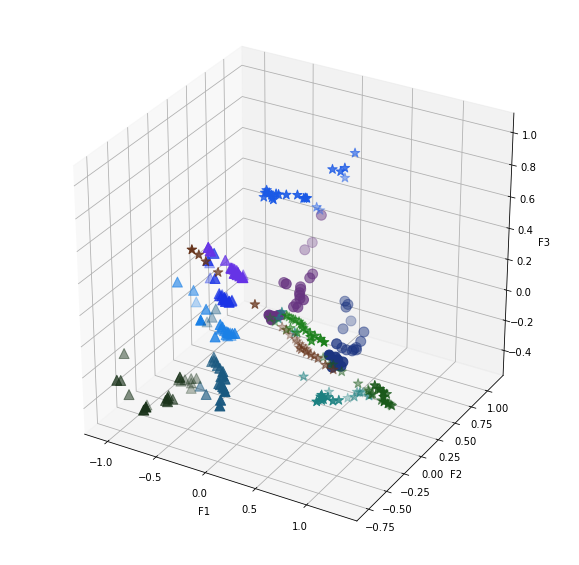

In [79]:
from mpl_toolkits.mplot3d import Axes3D
import time
fig= plt.figure(figsize= (10,10))
ax= fig.add_subplot(111, projection= '3d')

SuperSector= {'A': ['Durbl', 'Money'],
             'B': ['NoDur', 'Manuf', 'Chems', 'Shops', 'Other'],
             'C': ['Enrgy', 'BusEq','Telcm', 'Utils', 'Hlth']}
    
color_list= [ (x, y, z) 
             for x in np.linspace( 0.1, 0.7, 3) 
             for y in np.linspace (0.2, 0.5, 3) 
             for z in np.linspace( 0.1, 0.9, 3) ]
i=0


for ind in industry_ret.columns:

    tmp= industry_features_pca.loc[ind]
    F1= tmp['F1'].tolist()
    F2= tmp['F2'].tolist()
    F3= tmp['F3'].tolist()
    
    marker= ''
    if (ind in SuperSector['A']): 
        marker= 'o'
    elif ( ind in SuperSector['B']):
        marker= '^'
    else :
        marker= '*'
    
    ax.scatter( F1, F2, F3, c= color_list[i], marker= marker, s=100)
    i=i+1
    ax.set_xlabel( 'F1')
    ax.set_ylabel('F2')
    ax.set_zlabel('F3')
    print(ind)
    
plt.show()
    

In [75]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda= LDA( )
lda.fit( X= (industry_features- industry_features.mean())/ industry_features.std(), y= industry_features.index)
industry_features_lda= pd.DataFrame( lda.transform( industry_features))
industry_features_lda.index= industry_features.index
#industry_features_lda.columns= ['F1', 'F2', 'F3']

industry_features

,HML,R_SQ,CMA,RMW,Mkt-RF,MOM,MAE,SMB
LABEL,,,,,,,,
BusEq,-0.004916,0.759708,-0.775624,-0.075859,1.008448,-0.041559,2.168045,0.343674
BusEq,-0.108283,0.761986,-0.747307,-0.090679,1.061707,-0.041155,2.229665,0.251239
BusEq,-0.010788,0.772199,-1.055700,-0.166487,1.040807,0.017193,2.278772,0.121803
BusEq,-0.097954,0.812314,-1.201756,-0.274616,0.969397,0.126686,2.344267,0.030095
BusEq,-0.297279,0.824898,-0.907206,-0.311527,0.960488,0.151960,2.395127,0.162404
BusEq,-0.272387,0.860177,-0.926183,-0.276196,1.010680,0.021086,2.488303,0.113587
BusEq,-0.261427,0.872188,-0.905610,-0.315876,1.060523,-0.045224,2.516354,0.133149
BusEq,-0.518193,0.878200,-0.377410,-0.377096,1.188504,-0.159507,2.524307,0.058005
BusEq,-0.493152,0.874657,-0.357386,-0.410736,1.188674,-0.137926,2.512849,0.065033


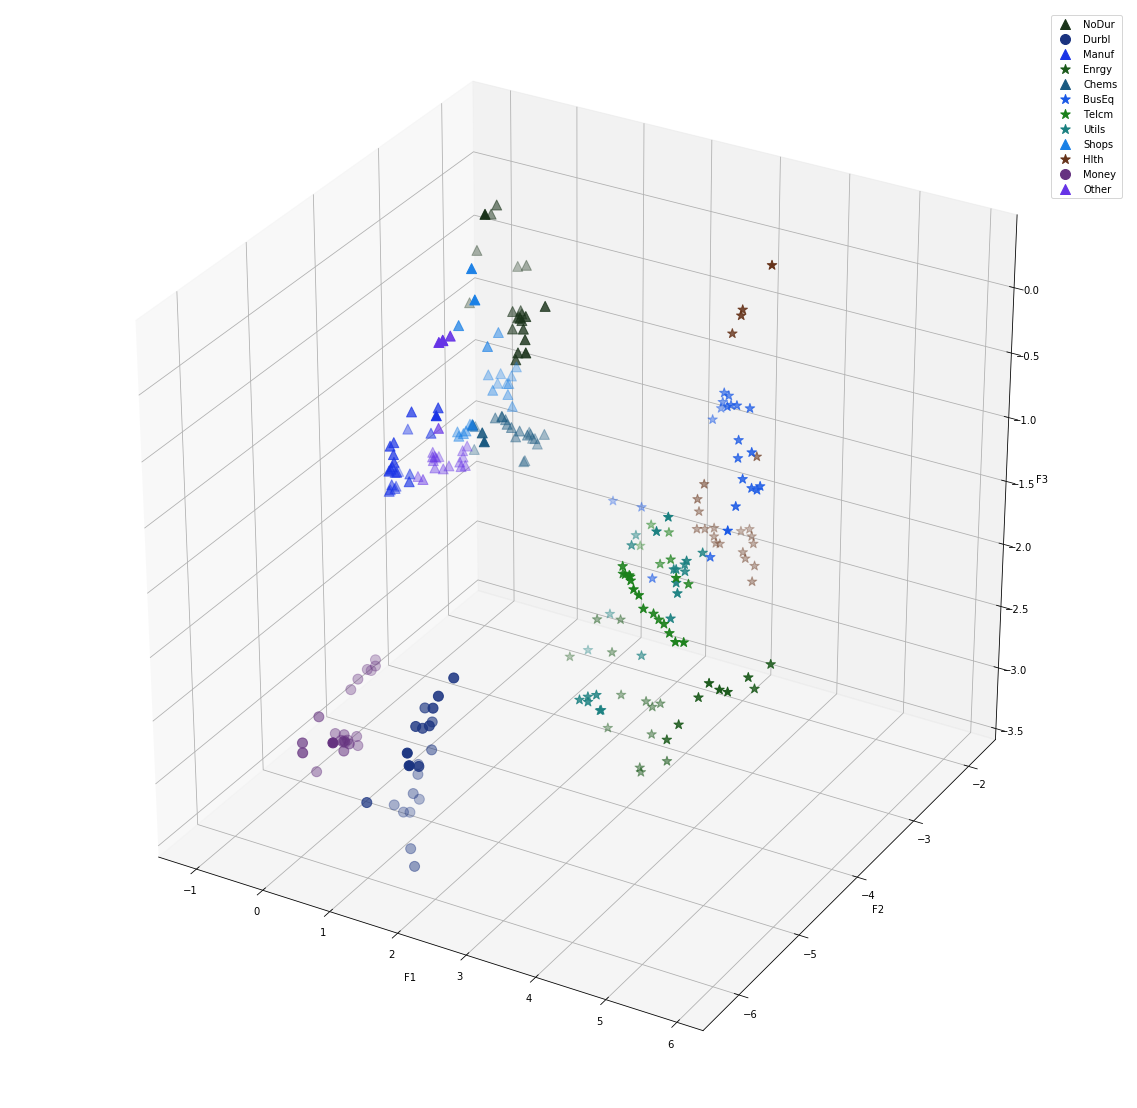

In [76]:
SuperSector= {'A': ['Durbl', 'Money'],
             'B': ['NoDur', 'Manuf', 'Chems', 'Shops', 'Other'],
             'C': ['Enrgy', 'BusEq','Telcm', 'Utils', 'Hlth']}
    
color_list= [ (x, y, z) 
             for x in np.linspace( 0.1, 0.7, 3) 
             for y in np.linspace (0.2, 0.5, 3) 
             for z in np.linspace( 0.1, 0.9, 3) ]
i=0
fig= plt.figure(figsize= (20,20))
ax= fig.add_subplot(111, projection= '3d')

for ind in industry_ret.columns:

#     if(ind== 'BusEq'):
#         continue
    tmp= industry_features_lda.loc[ind]
    F1= tmp[0].tolist()
    F2= tmp[1].tolist()
    F3= tmp[2].tolist()
    
    marker= ''
    if (ind in SuperSector['A']): 
        marker= 'o'
    elif ( ind in SuperSector['B']):
        marker= '^'
    else :
        marker= '*'
        
    ax.scatter( F1, F2, F3, c= color_list[i], marker= marker, s= 100, label= ind)
    
    ax.set_xlabel( 'F1')
    ax.set_ylabel('F2')
    ax.set_zlabel('F3')
    ax.legend()
    i=i+1
    if (i>13):
        break
    
plt.show()

In [40]:
from sklearn.cluster import KMeans

kmeans= KMeans( n_clusters= 3,  n_init= 5000).fit( industry_features_lda[[0,1,2]].values)
industry_features_lda['Group']= kmeans.labels_
# for ind in industry_ret.columns:
#     print( industry_features_lda.loc[ ind][['Group',7]])


In [41]:

for ind in industry_ret.columns:
    print( ind+ '   '+ str( np.unique( industry_features_lda.loc[ind,'Group'])))

NoDur   [1]
Durbl   [2]
Manuf   [1]
Enrgy   [0]
Chems   [1]
BusEq   [0]
Telcm   [0]
Utils   [0 1]
Shops   [1]
Hlth   [0]
Money   [2]
Other   [1]


In [42]:
# Group A : NonDurable Manufacture Chemicals Shops Other 
# Group B: Durable Money 
# Group C: Energy BusinessEquipment Telcom Utility Health 

SuperSector= {'A': ['Durbl', 'Money'],
             'B': ['NoDur', 'Manuf', 'Chems', 'Shops', 'Other'],
             'C': ['Enrgy', 'BusEq','Telcm', 'Utils', 'Hlth']}

industry_features_lda.loc['Enrgy']


,0,1,2,3,4,5,6,7,Group
LABEL,,,,,,,,,
Enrgy,2.087014,-3.927482,-2.546425,0.767277,-4.277365,3.635457,-2.011877,-7.586568,0
Enrgy,2.357020,-3.778728,-2.268103,0.766658,-4.304023,3.529205,-1.902691,-7.353144,0
Enrgy,2.610674,-3.675073,-2.274299,0.655890,-4.433764,3.582886,-2.033044,-7.539310,0
Enrgy,2.608325,-3.812540,-2.478130,0.641954,-4.558147,3.727383,-2.150710,-7.867782,0
Enrgy,2.854867,-3.936876,-2.727371,0.581072,-4.772799,3.820582,-2.109543,-8.118812,0
Enrgy,2.800967,-4.094837,-2.933847,0.590908,-4.859540,3.935241,-2.165717,-8.367727,0
Enrgy,3.357027,-3.851243,-2.753994,0.433923,-5.072172,3.944139,-2.277263,-8.483924,0
Enrgy,3.192421,-3.902767,-2.740183,0.486666,-5.026719,3.982282,-2.345555,-8.532358,0
Enrgy,3.283234,-3.901675,-2.770775,0.455319,-5.099108,4.028272,-2.403752,-8.653314,0


In [43]:
industry_longtermBeta

,Durbl,BusEq,Chems,Utils,Hlth,Manuf,Telcm,NoDur,Money,Shops,Enrgy,Other
CMA,NaN,-0.386500,0.334378,NaN,NaN,NaN,NaN,0.477713,-0.278814,NaN,NaN,NaN
HML,0.529336,-0.480025,NaN,0.361020,-0.119600,0.171132,NaN,-0.211013,0.752355,-0.088574,0.403826,0.165618
MOM,-0.293144,-0.097763,NaN,0.102822,0.094712,-0.082888,NaN,NaN,-0.053120,-0.050241,NaN,-0.052798
Mkt-RF,1.233520,1.129099,0.979997,0.520666,0.801332,1.160124,0.956367,0.881171,1.129934,0.995415,0.798757,1.053079
RMW,0.196681,-0.377106,0.458930,0.113512,NaN,0.320020,NaN,0.655864,0.041256,0.563473,NaN,NaN
SMB,0.341331,0.076576,NaN,-0.162858,-0.229492,0.224016,-0.231990,NaN,-0.077155,0.236105,NaN,0.169514


In [44]:
industry_ret.corr()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,1.000000,0.558182,0.700691,0.456960,0.775693,0.473405,0.597136,0.533709,0.748792,0.720296,0.708904,0.699770
Durbl,0.558182,1.000000,0.847217,0.492105,0.714326,0.635853,0.602871,0.332330,0.721042,0.463006,0.748295,0.806910
Manuf,0.700691,0.847217,1.000000,0.639241,0.842628,0.738752,0.675305,0.415495,0.804625,0.599191,0.795964,0.915916
Enrgy,0.456960,0.492105,0.639241,1.000000,0.577351,0.402173,0.443447,0.529791,0.417824,0.375377,0.503502,0.567960
Chems,0.775693,0.714326,0.842628,0.577351,1.000000,0.559837,0.564365,0.428157,0.729697,0.657309,0.734392,0.805462
BusEq,0.473405,0.635853,0.738752,0.402173,0.559837,1.000000,0.658089,0.193157,0.686153,0.524735,0.583977,0.764809
Telcm,0.597136,0.602871,0.675305,0.443447,0.564365,0.658089,1.000000,0.410468,0.659857,0.555690,0.648601,0.718827
Utils,0.533709,0.332330,0.415495,0.529791,0.428157,0.193157,0.410468,1.000000,0.324797,0.422199,0.430595,0.408783
Shops,0.748792,0.721042,0.804625,0.417824,0.729697,0.686153,0.659857,0.324797,1.000000,0.625686,0.759744,0.825002
Hlth,0.720296,0.463006,0.599191,0.375377,0.657309,0.524735,0.555690,0.422199,0.625686,1.000000,0.633443,0.650084


In [45]:
industry_ret.cov()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
NoDur,16.082990,15.481200,15.154189,9.895557,14.027605,13.315269,12.160162,8.389483,14.445169,13.266748,15.804939,14.287735
Durbl,15.481200,47.829011,31.598239,18.377331,22.276777,30.841538,21.171570,9.008690,23.987465,14.706265,28.770044,28.411572
Manuf,15.154189,31.598239,29.083412,18.615159,20.491273,27.941843,18.492920,8.782842,20.873452,14.840835,23.863731,25.147983
Enrgy,9.895557,18.377331,18.615159,29.158038,14.058193,15.230918,12.159173,11.213226,10.853011,9.309301,15.114814,15.614276
Chems,14.027605,22.276777,20.491273,14.058193,20.333909,17.705409,12.922715,7.567632,15.828173,13.612894,18.410287,18.491846
BusEq,13.315269,30.841538,27.941843,15.230918,17.705409,49.188929,23.436953,5.309947,23.149039,16.902228,22.769390,27.309358
Telcm,12.160162,21.171570,18.492920,12.159173,12.922715,23.436953,25.784933,8.169769,16.117978,12.959433,18.309770,18.583701
Utils,8.389483,9.008690,8.782842,11.213226,7.567632,5.309947,8.169769,15.363635,6.124035,7.600365,9.382922,8.157642
Shops,14.445169,23.987465,20.873452,10.853011,15.828173,23.149039,16.117978,6.124035,23.139610,13.823087,20.317370,20.204954
Hlth,13.266748,14.706265,14.840835,9.309301,13.612894,16.902228,12.959433,7.600365,13.823087,21.093106,16.173349,15.200724


In [90]:
tmp = industry_ret[ SuperSector['A']+ SuperSector['B']+ SuperSector['C']]
SIGMA= tmp.cov()
CORR= tmp.corr()
SIGMA


,Durbl,Money,NoDur,Manuf,Chems,Shops,Other,Enrgy,BusEq,Telcm,Utils,Hlth
Durbl,47.829011,28.770044,15.481200,31.598239,22.276777,23.987465,28.411572,18.377331,30.841538,21.171570,9.008690,14.706265
Money,28.770044,30.906119,15.804939,23.863731,18.410287,20.317370,23.123726,15.114814,22.769390,18.309770,9.382922,16.173349
NoDur,15.481200,15.804939,16.082990,15.154189,14.027605,14.445169,14.287735,9.895557,13.315269,12.160162,8.389483,13.266748
Manuf,31.598239,23.863731,15.154189,29.083412,20.491273,20.873452,25.147983,18.615159,27.941843,18.492920,8.782842,14.840835
Chems,22.276777,18.410287,14.027605,20.491273,20.333909,15.828173,18.491846,14.058193,17.705409,12.922715,7.567632,13.612894
Shops,23.987465,20.317370,14.445169,20.873452,15.828173,23.139610,20.204954,10.853011,23.149039,16.117978,6.124035,13.823087
Other,28.411572,23.123726,14.287735,25.147983,18.491846,20.204954,25.920861,15.614276,27.309358,18.583701,8.157642,15.200724
Enrgy,18.377331,15.114814,9.895557,18.615159,14.058193,10.853011,15.614276,29.158038,15.230918,12.159173,11.213226,9.309301
BusEq,30.841538,22.769390,13.315269,27.941843,17.705409,23.149039,27.309358,15.230918,49.188929,23.436953,5.309947,16.902228
Telcm,21.171570,18.309770,12.160162,18.492920,12.922715,16.117978,18.583701,12.159173,23.436953,25.784933,8.169769,12.959433


In [91]:
a= np.arange( 9).reshape( (3,3))    
b= np.arange( 3)

In [92]:
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [93]:
b

array([0, 1, 2])

In [94]:
np.dot( a,b).transpose()

array([ 5, 14, 23])

In [95]:
np.dot(b ,a)

array([15, 18, 21])

In [96]:
def objective_func( w, sigma):
    # w, np.array, the weight to be optimized 
    # sigma, np.array, the cov matrix
    
    # return w.T* sigma* w* 0.5
    
    return ( np.dot( np.dot( w, sigma), w)* 0.5)

def objective_func_deriv( w, sigma):
    # w, np.array, the weight to be optimized
    # sigma, np.array, the cov matrix
    
    # return w.T* sigma
    
    return ( np.dot( w, sigma))

def sparse_array( l, k):
    return ( np.array( [0]*k+ [1]+ [0]* (l-k-1)))

cons_eq0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*12)}
cons_ineq0= {'type': 'ineq', 
             'fun': lambda w: -w[0]-w[1]+ 0.5, 
             'jac': lambda w: np.array([-1]*2+ [0]*10)}
cons_ineq1= {'type': 'ineq',
             'fun': lambda w: -w[2]-w[3]-w[4]-w[5]-w[6]+ 0.5,
             'jac': lambda w: np.array([0]*2+ [-1]*5+ [0]*5)}
cons_ineq2= {'type': 'ineq', 
             'fun': lambda w: -w[7]-w[8]-w[9]-w[10]-w[11]+ 0.5, 
             'jac': lambda w: np.array([0]*7+ [-1]*5)}

cons= (cons_eq0,
      cons_ineq0,
      cons_ineq1,
      cons_ineq2
      )

             


In [97]:
from scipy.optimize import minimize 

opt_res= minimize( objective_func, 
                  x0=[ 1/12.0]* 12,
                  args= SIGMA, 
                  jac= objective_func_deriv, 
                  method= 'SLSQP',
                  options= {'disp': True},
                  constraints= cons,
                  bounds= [[0, None]]*12
                 )

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5.781084705094608
            Iterations: 11
            Function evaluations: 16
            Gradient evaluations: 11


In [98]:
opt_res.x

array([  2.08365102e-15,   5.12219572e-15,   2.55374261e-01,
         1.66806289e-15,   1.07127885e-01,   1.37497854e-01,
         1.85431738e-16,   2.69891957e-03,   0.00000000e+00,
         7.15126031e-03,   4.51371392e-01,   3.87784278e-02])

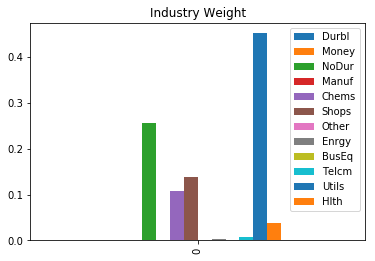

In [104]:
pd.DataFrame( opt_res.x, index=SIGMA.columns).transpose().plot( kind= 'bar', title= 'Industry Weight')

In [56]:
CORR

,Durbl,Money,NoDur,Manuf,Chems,Shops,Other,Enrgy,BusEq,Telcm,Utils,Hlth
Durbl,1.000000,0.748295,0.558182,0.847217,0.714326,0.721042,0.806910,0.492105,0.635853,0.602871,0.332330,0.463006
Money,0.748295,1.000000,0.708904,0.795964,0.734392,0.759744,0.816979,0.503502,0.583977,0.648601,0.430595,0.633443
NoDur,0.558182,0.708904,1.000000,0.700691,0.775693,0.748792,0.699770,0.456960,0.473405,0.597136,0.533709,0.720296
Manuf,0.847217,0.795964,0.700691,1.000000,0.842628,0.804625,0.915916,0.639241,0.738752,0.675305,0.415495,0.599191
Chems,0.714326,0.734392,0.775693,0.842628,1.000000,0.729697,0.805462,0.577351,0.559837,0.564365,0.428157,0.657309
Shops,0.721042,0.759744,0.748792,0.804625,0.729697,1.000000,0.825002,0.417824,0.686153,0.659857,0.324797,0.625686
Other,0.806910,0.816979,0.699770,0.915916,0.805462,0.825002,1.000000,0.567960,0.764809,0.718827,0.408783,0.650084
Enrgy,0.492105,0.503502,0.456960,0.639241,0.577351,0.417824,0.567960,1.000000,0.402173,0.443447,0.529791,0.375377
BusEq,0.635853,0.583977,0.473405,0.738752,0.559837,0.686153,0.764809,0.402173,1.000000,0.658089,0.193157,0.524735
Telcm,0.602871,0.648601,0.597136,0.675305,0.564365,0.659857,0.718827,0.443447,0.658089,1.000000,0.410468,0.555690


In [57]:
Portf1_w= opt_res.x
Portf2_w= [1/12]*12

ret_data= industry_ret[SIGMA.columns]/100
rebalance_date= ret_data.index


In [58]:
from portfolio_rebalance import rebalance

Portf1_res= rebalance( ret_data= ret_data, target_weight= Portf1_w, rebalance_date= rebalance_date)
Portf2_res= rebalance( ret_data= ret_data, target_weight= Portf2_w, rebalance_date= rebalance_date)

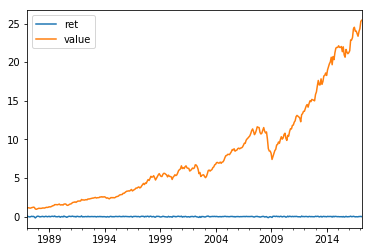

In [59]:
Portf1_res.plot()

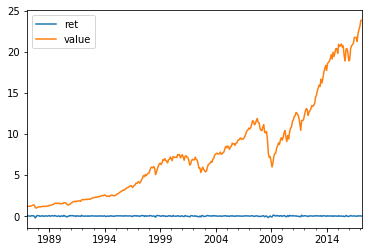

In [60]:
Portf2_res.plot()

In [61]:
P= pd.DataFrame( [Portf1_res['value'], Portf2_res['value'], Portf1_res['ret'], Portf2_res['ret']]).T
P.columns= ['P1_value', 'P2_value', 'P1_ret', 'P2_ret']
P.corr()

,P1_value,P2_value,P1_ret,P2_ret
P1_value,1.000000,0.993742,-0.001775,-0.009361
P2_value,0.993742,1.000000,-0.000299,-0.002568
P1_ret,-0.001775,-0.000299,1.000000,0.860604
P2_ret,-0.009361,-0.002568,0.860604,1.000000


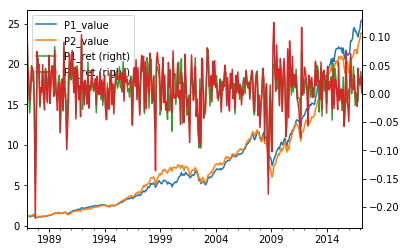

In [62]:
P.plot(secondary_y= ['P1_ret', 'P2_ret'])

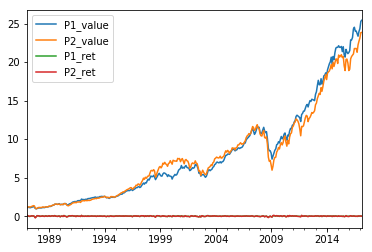

In [63]:
P.plot()

In [64]:
P.describe()

,P1_value,P2_value,P1_ret,P2_ret
count,363.000000,363.000000,363.000000,363.000000
mean,7.961999,7.837666,0.009536,0.009668
std,6.389592,5.847057,0.034003,0.041876
min,0.953845,0.970398,-0.159528,-0.219675
25%,2.534465,2.509294,-0.009274,-0.012917
50%,6.081571,6.892395,0.012318,0.014250
75%,10.868956,10.651873,0.031881,0.036050
max,25.423071,23.845738,0.116567,0.129808


In [65]:
r1= np.dot( ret_data.values, np.array( opt_res.x))
r2= np.dot( ret_data.values, np.array( [1/12]*12))

In [66]:
r1= pd.Series( r1, name= 'r1', index= ret_data.index)
r2= pd.Series( r2, name= 'r2', index= ret_data.index)
P= pd.concat( [P, r1, r2], axis= 1)

In [67]:
np.max( P['P1_ret']- P['r1'])

1.3877787807814457e-17

In [68]:
np.max( P['P2_ret']- P['r2'])

2.7755575615628914e-17

In [69]:
P

,P1_value,P2_value,P1_ret,P2_ret,r1,r2
1987-01-01,1.116567,1.129808,0.116567,0.129808,0.116567,0.129808
1987-02-01,1.147703,1.183051,0.027885,0.047125,0.027885,0.047125
1987-03-01,1.151540,1.214007,0.003344,0.026167,0.003344,0.026167
1987-04-01,1.112219,1.198124,-0.034146,-0.013083,-0.034146,-0.013083
1987-05-01,1.111979,1.207569,-0.000216,0.007883,-0.000216,0.007883
1987-06-01,1.167296,1.263932,0.049746,0.046675,0.049746,0.046675
1987-07-01,1.193578,1.321873,0.022515,0.045842,0.022515,0.045842
1987-08-01,1.235708,1.371983,0.035298,0.037908,0.035298,0.037908
1987-09-01,1.201281,1.344086,-0.027860,-0.020333,-0.027860,-0.020333
1987-10-01,1.009643,1.048824,-0.159528,-0.219675,-0.159528,-0.219675
